In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Dataset Information:

This dataset consists of Monte Carlo (MC) generated data simulating high-energy gamma particle registration in a Cherenkov gamma telescope using imaging techniques. The telescope detects gamma rays by capturing the Cherenkov radiation emitted by charged particles formed in electromagnetic showers initiated by gamma interactions in the atmosphere.

The recorded data include pulses from Cherenkov photons impacting the photomultiplier tubes arranged in a plane (the camera). Depending on the gamma energy, anywhere from a few hundred to 10,000 photons are collected, forming a shower image that helps distinguish between gamma-initiated showers (signal) and hadronic showers caused by cosmic rays (background).

After pre-processing, the shower image generally appears as an elongated cluster, with its long axis pointing toward the camera center if the telescope is aligned with a point source. A principal component analysis (PCA) is performed to determine correlation axes and define an ellipse, aiding in classification. Features such as Hillas parameters, asymmetry along the major axis, and cluster extent further assist in discrimination.

The data was produced by the Monte Carlo simulation program Corsika, detailed in:

D. Heck et al., CORSIKA: A Monte Carlo Code to Simulate Extensive Air Showers, Forschungszentrum Karlsruhe FZKA 6019 (1998).
http://rexa.info/paper?id=ac6e674e9af20979b23d3ed4521f1570765e8d68
Simulation parameters enabled the detection of events with **energies below 50 GeV

src:

[https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope]

# Data Preperation

In [2]:
cols = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
url = "https://raw.githubusercontent.com/usernameneo/Data-Science-Projects/refs/heads/main/fcc-MAGIC/magic04.data"
df = pd.read_csv(url, names=cols)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [3]:
df["class"].unique()

array(['g', 'h'], dtype=object)

In [4]:
df["class"] = (df["class"] == "g").astype(int)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


Class Values
The only class values are either "g" for gamma particles or "h" for hadron particles. In order to assist in computation of our data, these will be converted to binary values, 0 for hadrons and 1 for gamma.

We will use the features of the DataFrame to determine wheather a recorded particle is a gamma or a hadron particle.

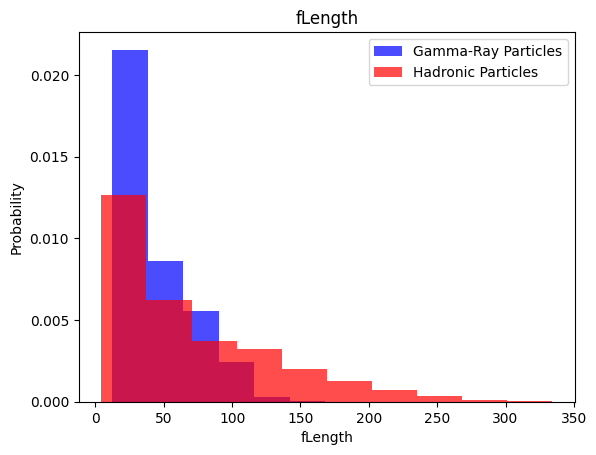

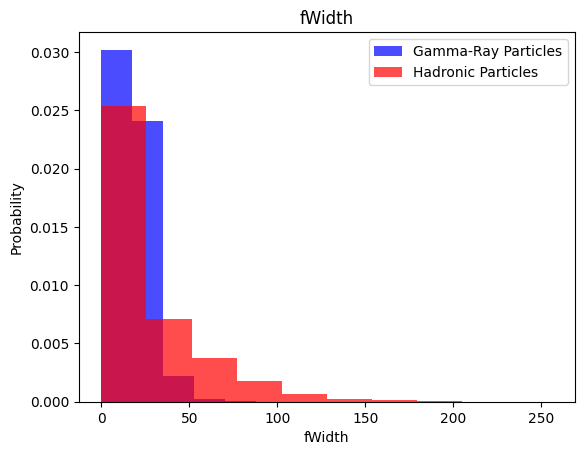

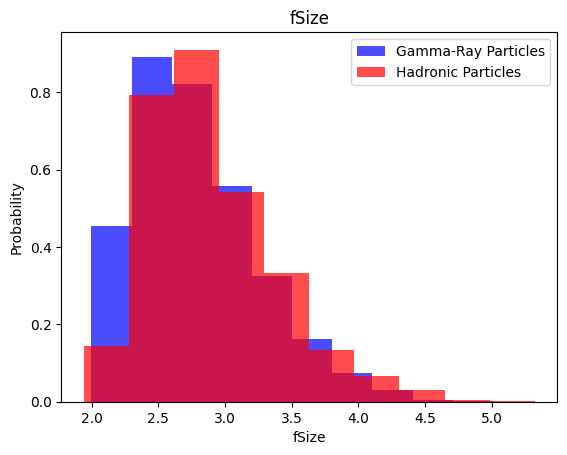

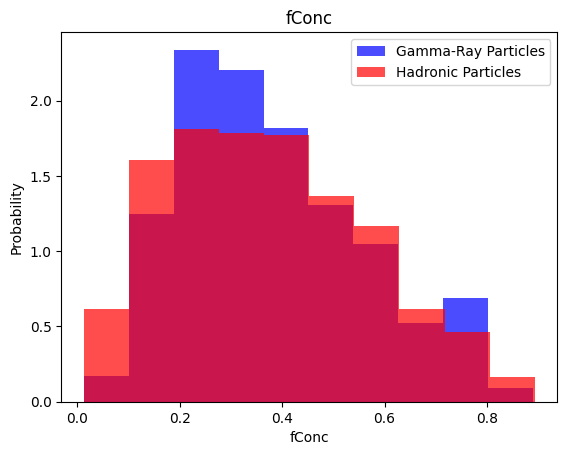

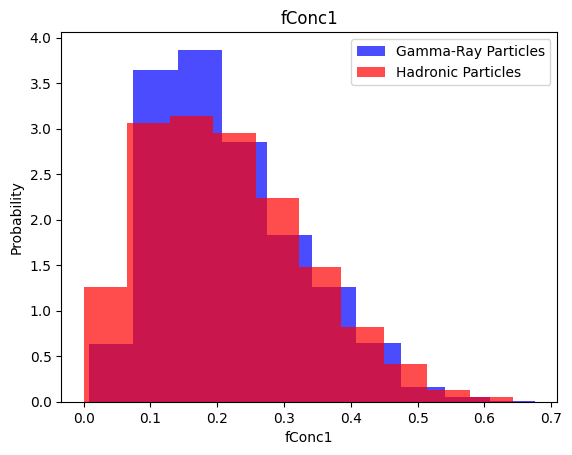

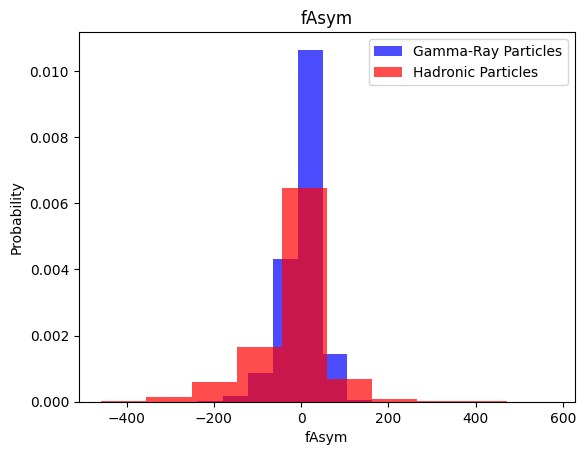

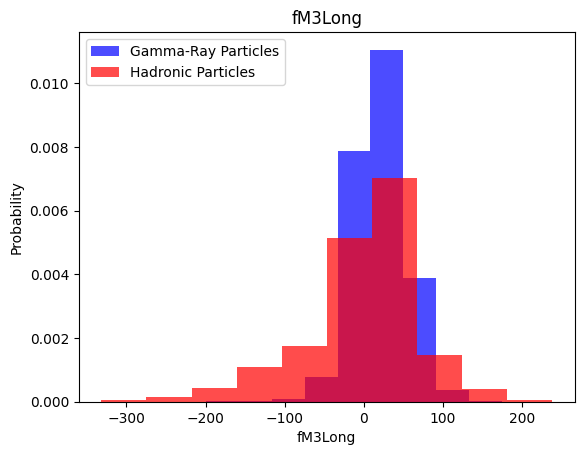

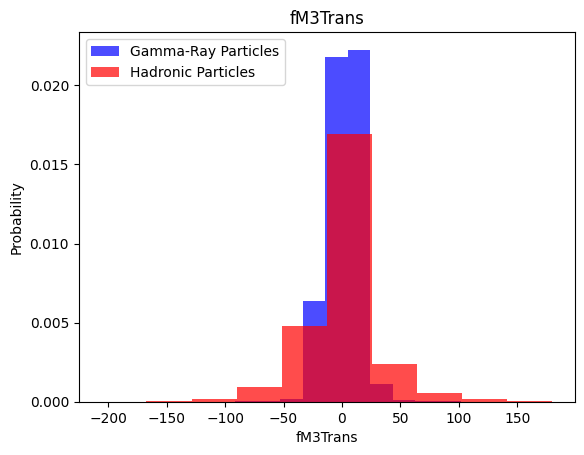

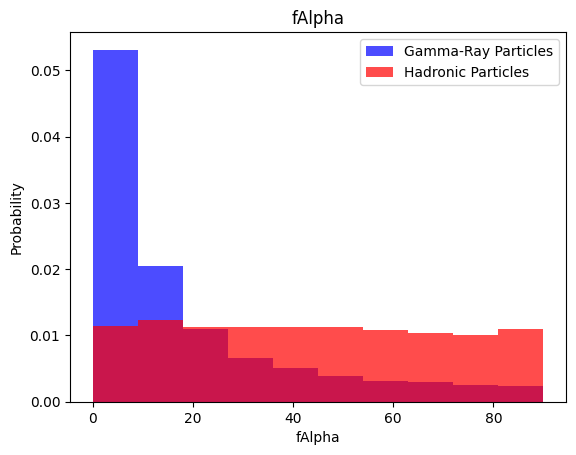

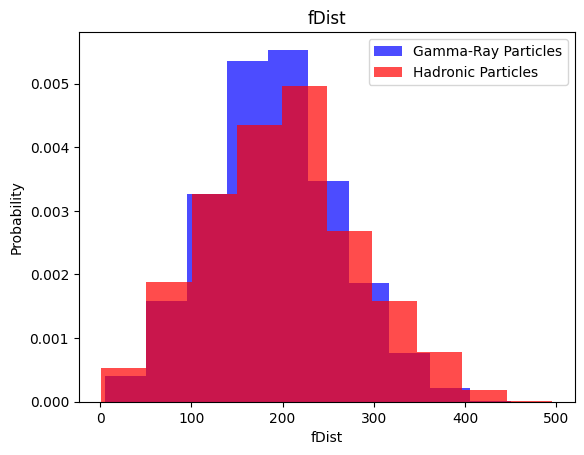

In [5]:
for col in cols[:-1]:
    plt.hist(df[df["class"]==1][col], color="blue", label="Gamma-Ray Particles", alpha=0.7, density=True)
    plt.hist(df[df["class"]==0][col], color="red", label="Hadronic Particles", alpha=0.7, density=True)
    plt.title(col)
    plt.ylabel("Probability")
    plt.xlabel(col)
    plt.legend()
    plt.show()

# Train, Validation and Test datasets

In [6]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/home/codespace/.python/current/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
def scale_dataset(dataframe, oversample=False):
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))
    return data, X, y

In [8]:
print("Gamma", len(train[train["class"]==1]))
print("Hadron:", len(train[train["class"]==0]))

Gamma 7430
Hadron: 3982


In [9]:
train, X_train, y_train = scale_dataset(train, oversample=True)
val, X_val, y_val = scale_dataset(val, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

In [10]:
print("Total:", len(y_train))
print("Gamma:", sum(y_train==1))
print("Hadron:", sum(y_train==0))

Total: 14860
Gamma: 7430
Hadron: 7430


# Classification Models

## K-Nearest Neighbors

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_predicts = knn_model.predict(X_test)
print(classification_report(y_test, y_predicts))

              precision    recall  f1-score   support

           0       0.76      0.73      0.75      1364
           1       0.85      0.87      0.86      2440

    accuracy                           0.82      3804
   macro avg       0.81      0.80      0.80      3804
weighted avg       0.82      0.82      0.82      3804



## Naive Bayes

In [12]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)

y_predicts = nb_model.predict(X_test)
print(classification_report(y_test, y_predicts))

              precision    recall  f1-score   support

           0       0.69      0.38      0.49      1364
           1       0.72      0.90      0.80      2440

    accuracy                           0.72      3804
   macro avg       0.71      0.64      0.65      3804
weighted avg       0.71      0.72      0.69      3804



## Logistic Progression

In [13]:
from sklearn.linear_model import LogisticRegression

lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train, y_train)

y_predicts = lg_model.predict(X_test)
print(classification_report(y_test, y_predicts))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1364
           1       0.84      0.82      0.83      2440

    accuracy                           0.78      3804
   macro avg       0.76      0.77      0.77      3804
weighted avg       0.78      0.78      0.78      3804



## Support Vector Machine

In [14]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

y_predicts = svm_model.predict(X_test)
print(classification_report(y_test, y_predicts))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1364
           1       0.89      0.90      0.89      2440

    accuracy                           0.86      3804
   macro avg       0.85      0.85      0.85      3804
weighted avg       0.86      0.86      0.86      3804



## Neural Network

In [15]:
import tensorflow as tf

2025-06-05 11:06:18.234365: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 11:06:18.479721: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 11:06:18.621443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749121578.961732    5634 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749121579.057890    5634 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749121579.675661    5634 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [16]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history["loss"], label="loss")
    ax1.plot(history.history["val_loss"], label="val_loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Binary Crossentropy")
    ax1.grid(True)

    ax2.plot(history.history["loss"], label="loss")
    ax2.plot(history.history["val_accuracy"], label="val_accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.grid(True)

    plt.show()

In [17]:
def train_model(X_train, y_train, n_nodes, dropout_prob, lr, batch_size, epochs):
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(n_nodes, activation="relu", input_shape=(10,)),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(n_nodes, activation="relu"),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="binary_crossentropy",
                    metrics=["accuracy"]
                    )
    
    history = nn_model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, 
        verbose=0
    )
    
    return nn_model, history   

nodes: 16, droupout: 0, lr: 0.01, batch size 32


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-05 11:06:24.275407: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


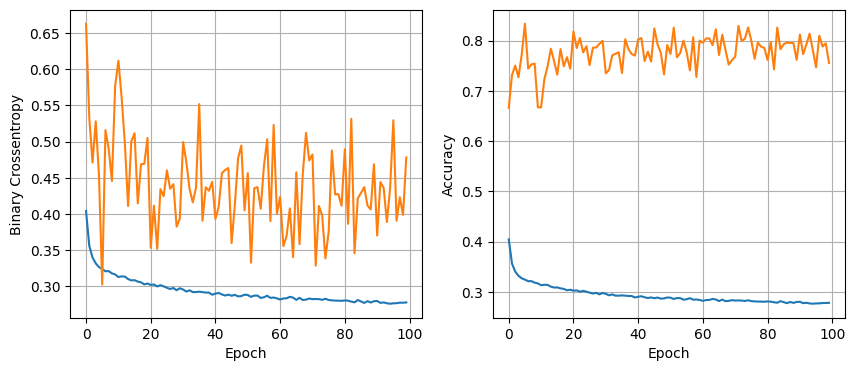

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8589 - loss: 0.3465
nodes: 16, droupout: 0, lr: 0.01, batch size 64


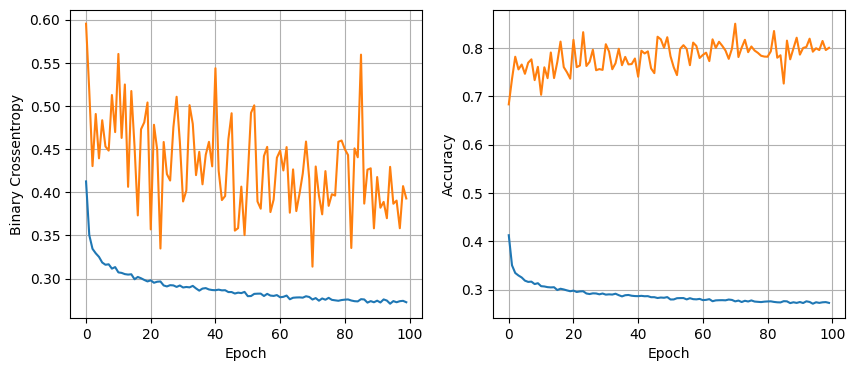

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8537 - loss: 0.3574  
nodes: 16, droupout: 0, lr: 0.005, batch size 32


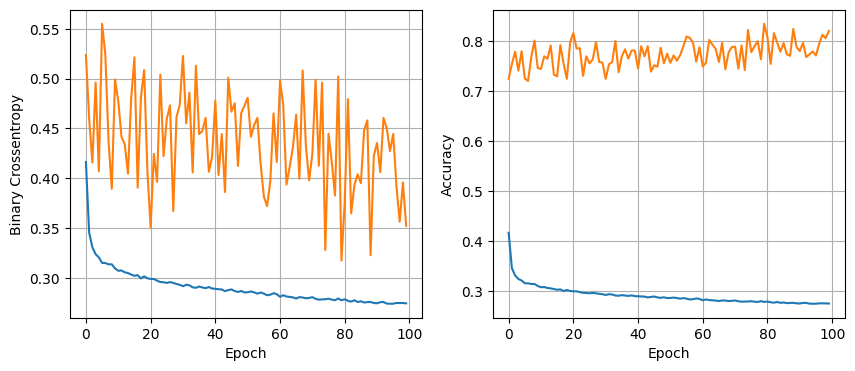

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8572 - loss: 0.3491  
nodes: 16, droupout: 0, lr: 0.005, batch size 64


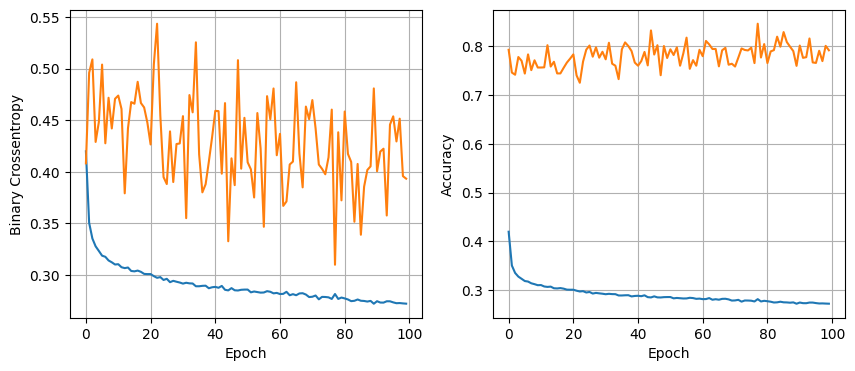

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8708 - loss: 0.3256  
nodes: 16, droupout: 0, lr: 0.001, batch size 32


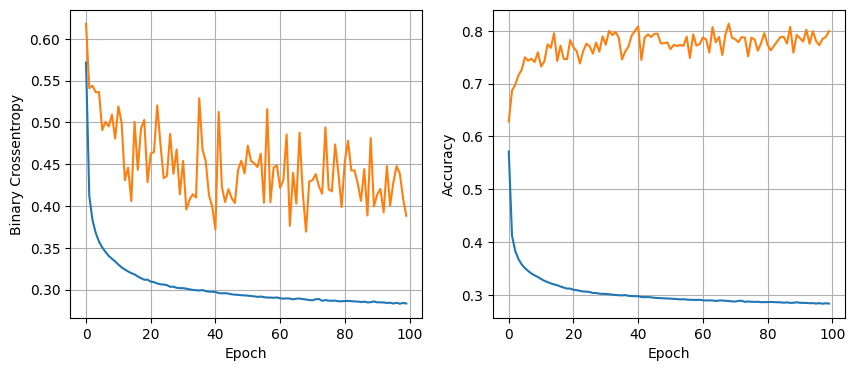

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8585 - loss: 0.3264  
nodes: 16, droupout: 0, lr: 0.001, batch size 64


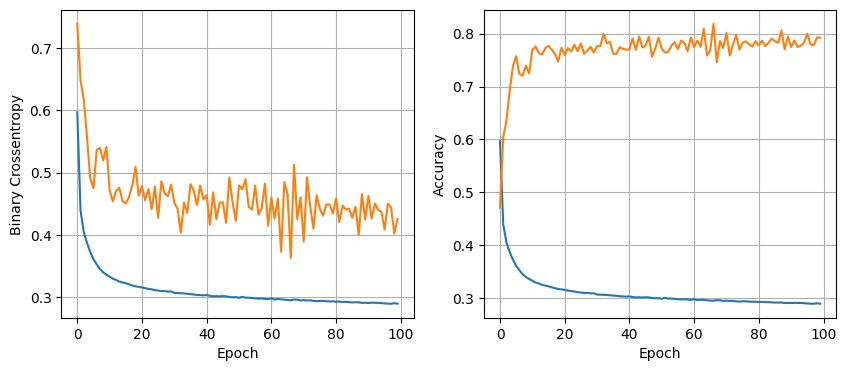

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8601 - loss: 0.3187  
nodes: 16, droupout: 0.2, lr: 0.01, batch size 32


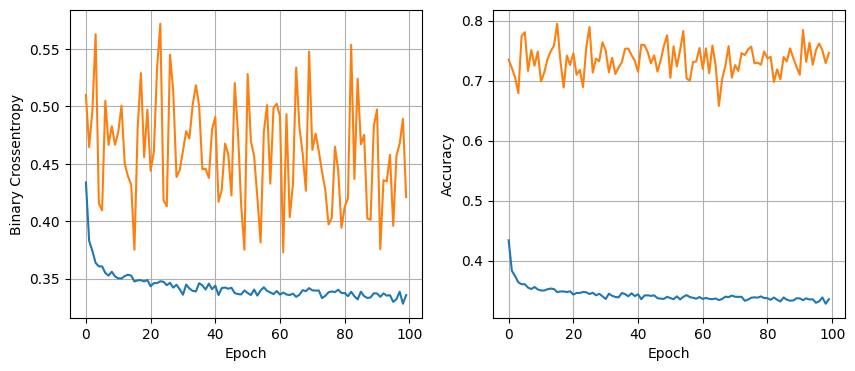

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8608 - loss: 0.3459  
nodes: 16, droupout: 0.2, lr: 0.01, batch size 64


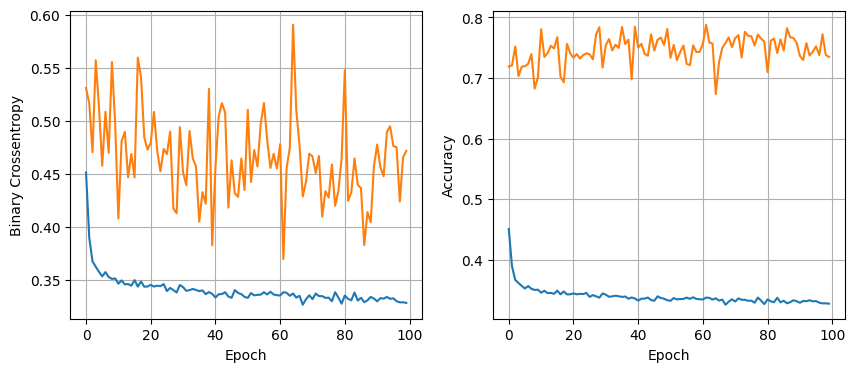

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8657 - loss: 0.3215  
nodes: 16, droupout: 0.2, lr: 0.005, batch size 32


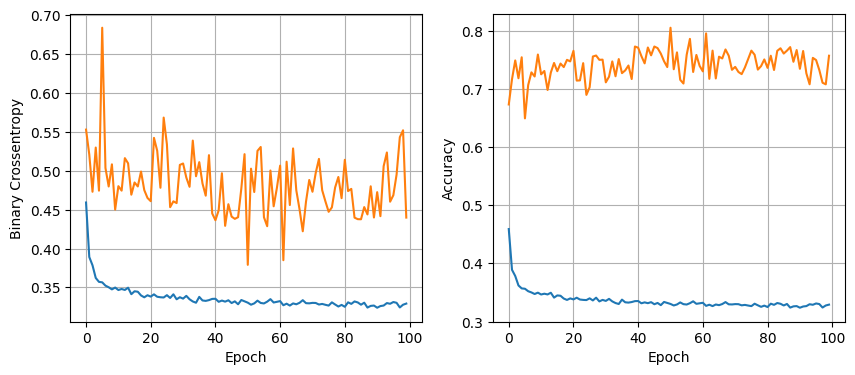

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8588 - loss: 0.3225  
nodes: 16, droupout: 0.2, lr: 0.005, batch size 64


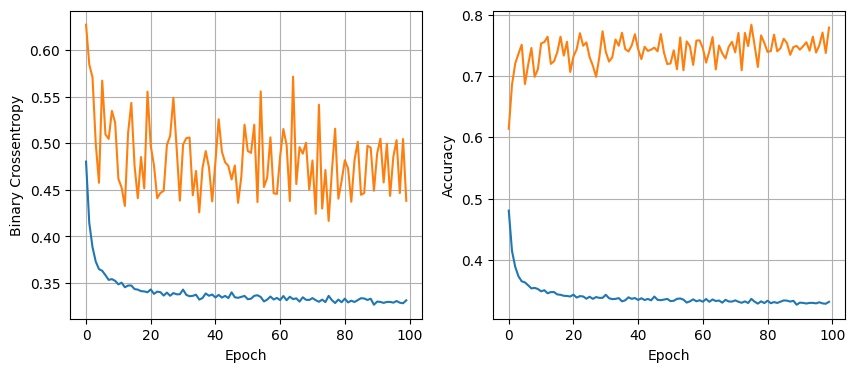

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8588 - loss: 0.3321  
nodes: 16, droupout: 0.2, lr: 0.001, batch size 32


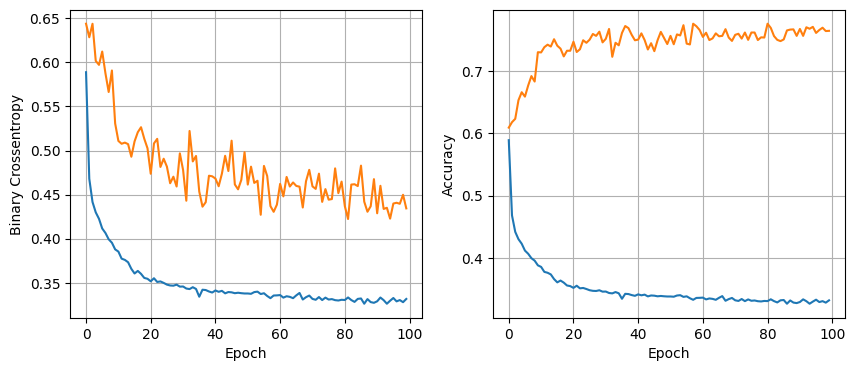

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8573 - loss: 0.3242  
nodes: 16, droupout: 0.2, lr: 0.001, batch size 64


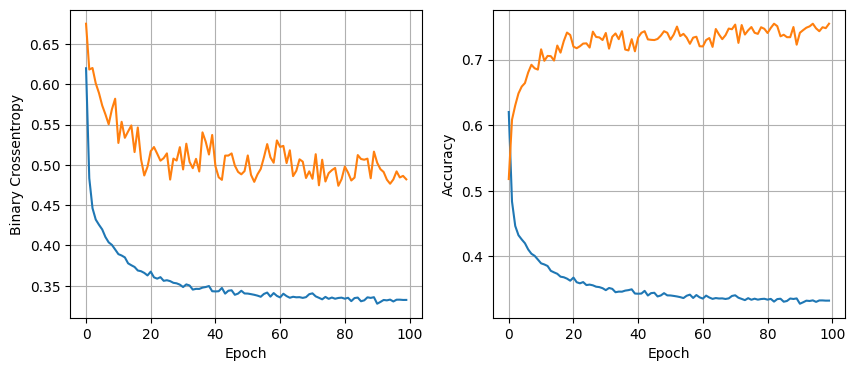

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8602 - loss: 0.3267  
nodes: 32, droupout: 0, lr: 0.01, batch size 32


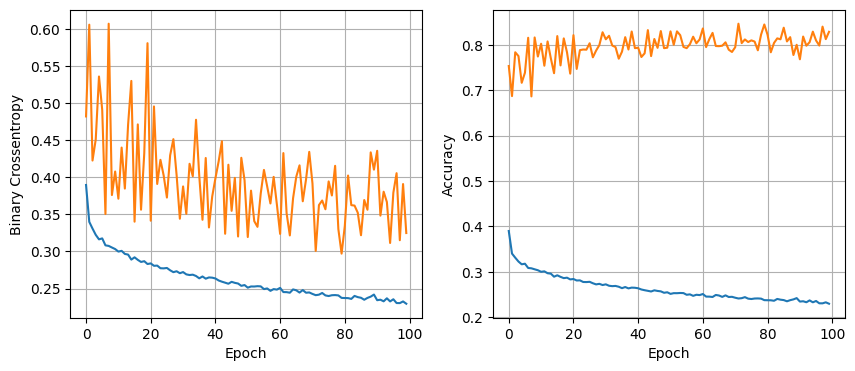

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8614 - loss: 0.3969  
nodes: 32, droupout: 0, lr: 0.01, batch size 64


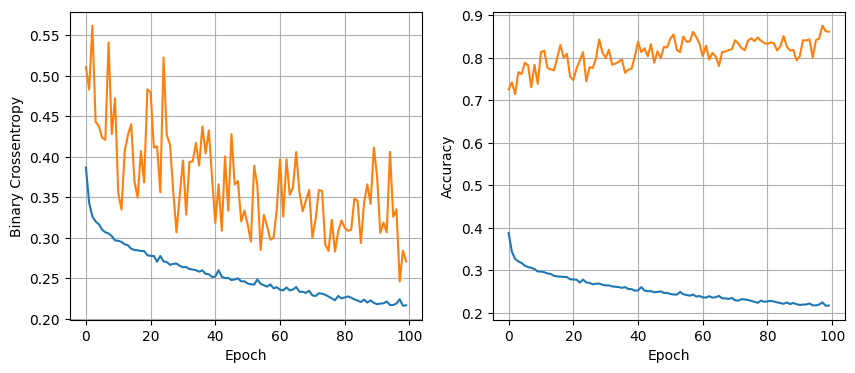

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8633 - loss: 0.4004  
nodes: 32, droupout: 0, lr: 0.005, batch size 32


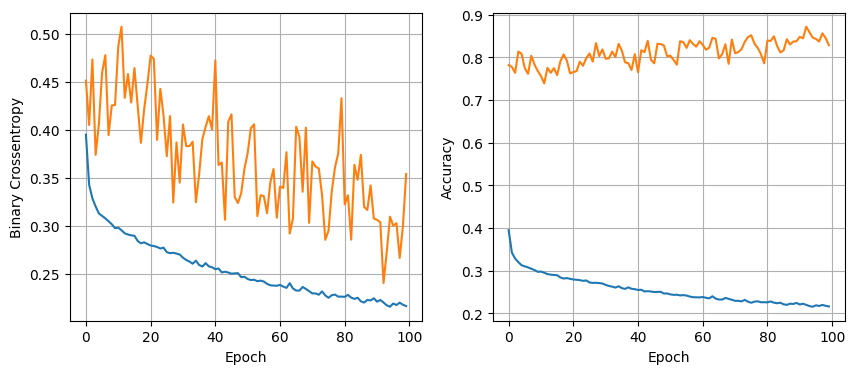

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8614 - loss: 0.4330  
nodes: 32, droupout: 0, lr: 0.005, batch size 64


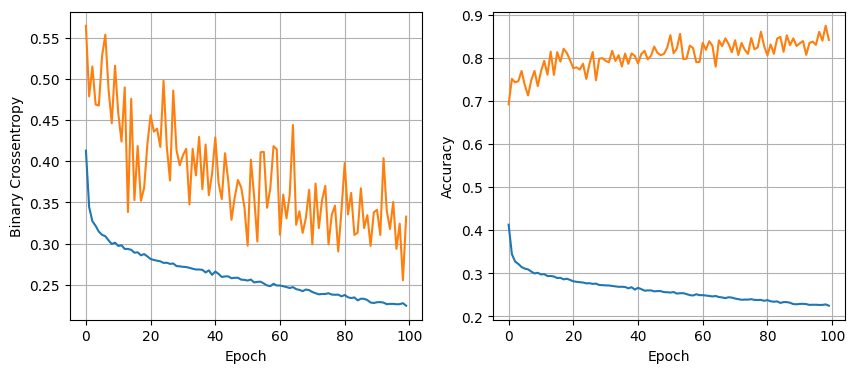

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8635 - loss: 0.3595  
nodes: 32, droupout: 0, lr: 0.001, batch size 32


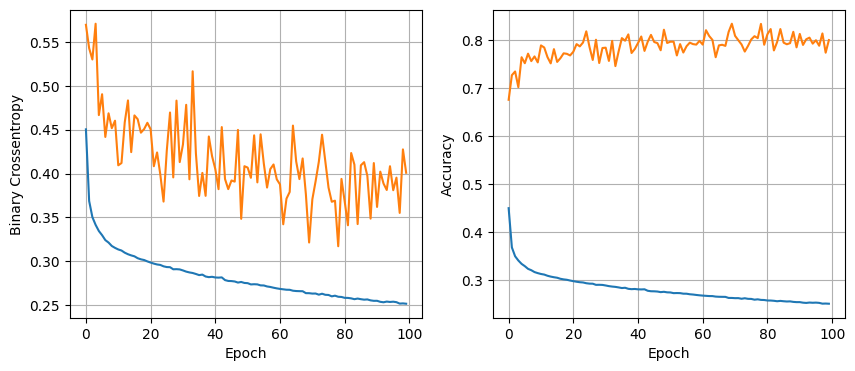

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8601 - loss: 0.3401
nodes: 32, droupout: 0, lr: 0.001, batch size 64


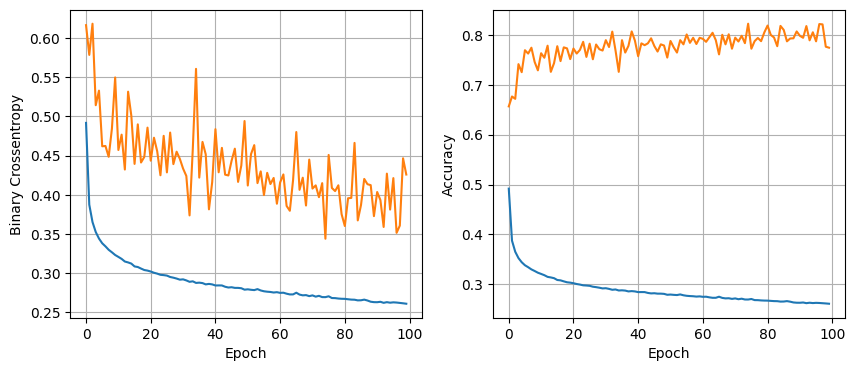

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.8667 - loss: 0.3249
nodes: 32, droupout: 0.2, lr: 0.01, batch size 32


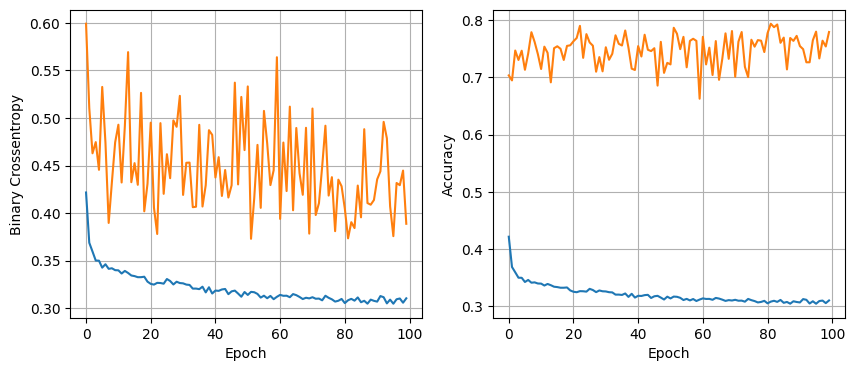

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.8631 - loss: 0.3281
nodes: 32, droupout: 0.2, lr: 0.01, batch size 64


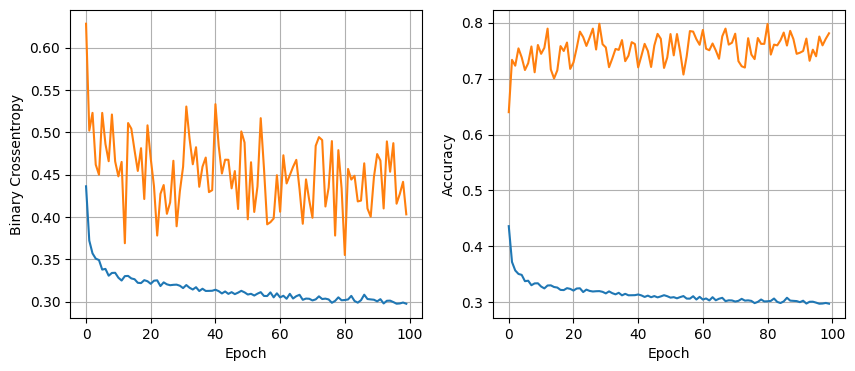

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8686 - loss: 0.3236
nodes: 32, droupout: 0.2, lr: 0.005, batch size 32


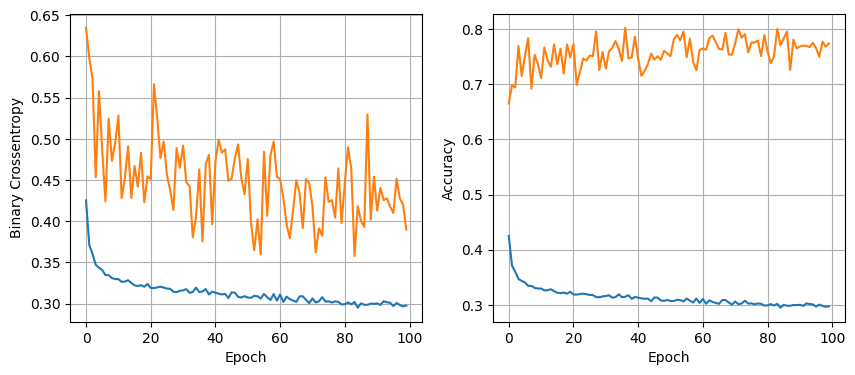

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.8600 - loss: 0.3222
nodes: 32, droupout: 0.2, lr: 0.005, batch size 64


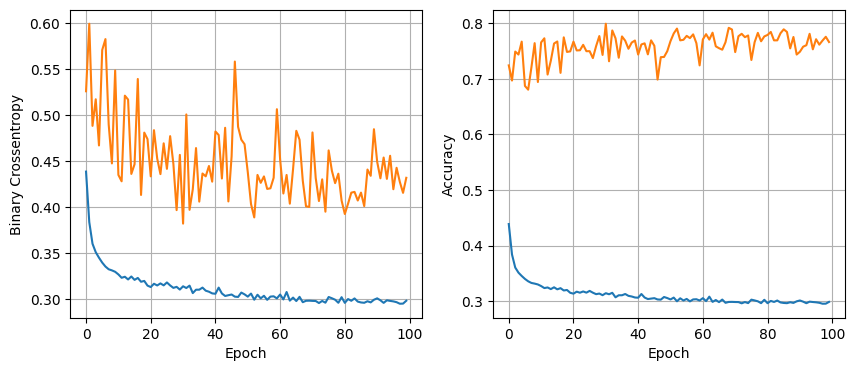

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8641 - loss: 0.3114  
nodes: 32, droupout: 0.2, lr: 0.001, batch size 32


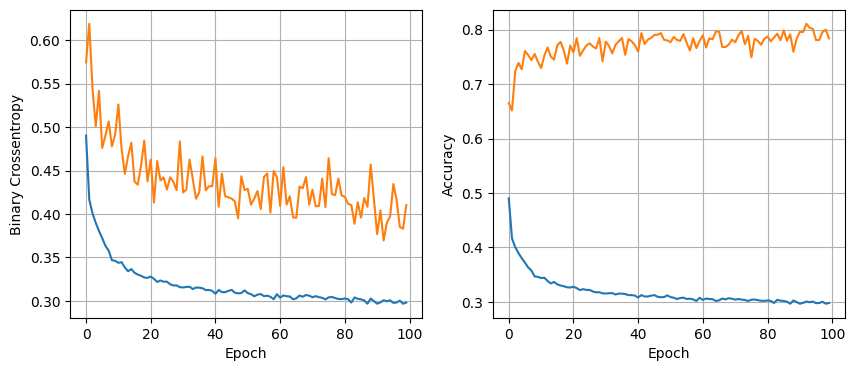

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8640 - loss: 0.3154  
nodes: 32, droupout: 0.2, lr: 0.001, batch size 64


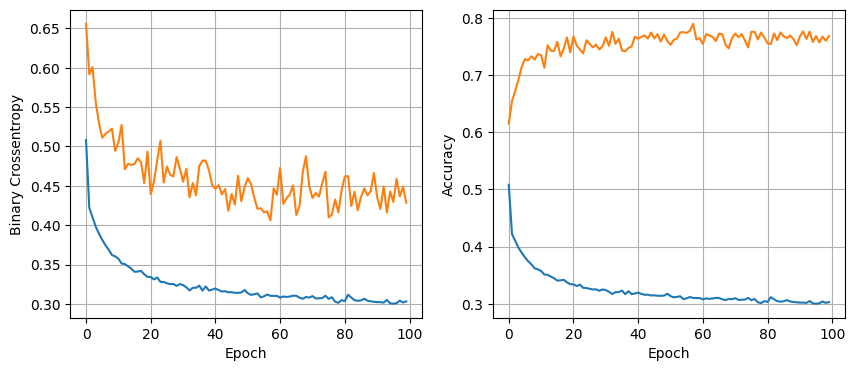

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8656 - loss: 0.3151  
nodes: 128, droupout: 0, lr: 0.01, batch size 32


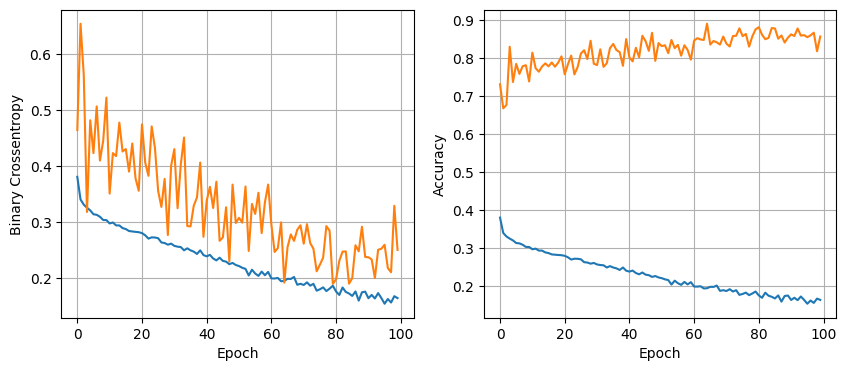

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8585 - loss: 0.6691  
nodes: 128, droupout: 0, lr: 0.01, batch size 64


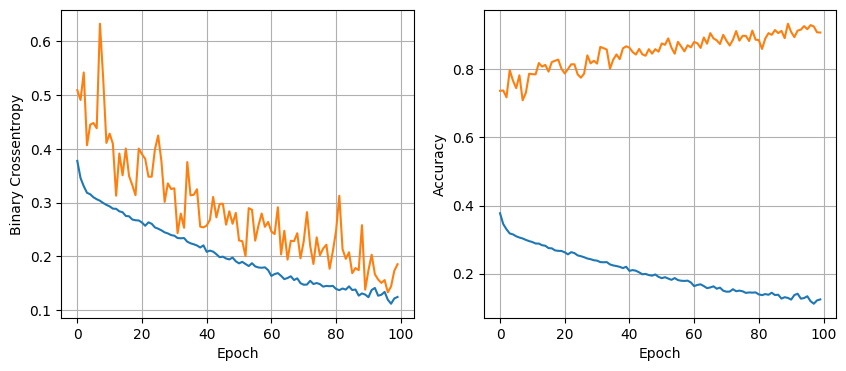

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8645 - loss: 0.7248  
nodes: 128, droupout: 0, lr: 0.005, batch size 32


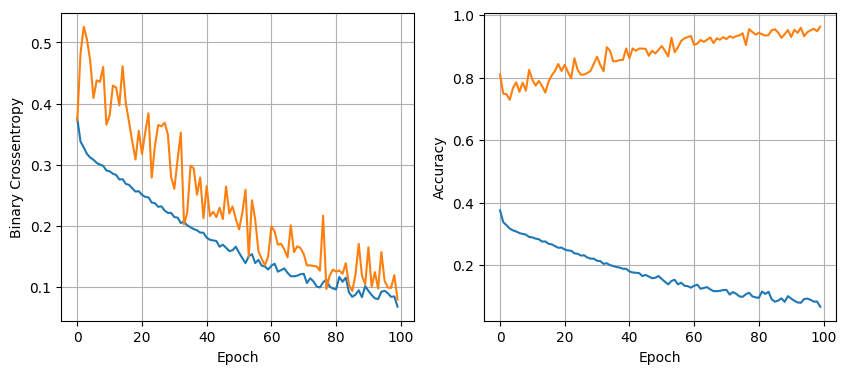

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8555 - loss: 0.8564  
nodes: 128, droupout: 0, lr: 0.005, batch size 64


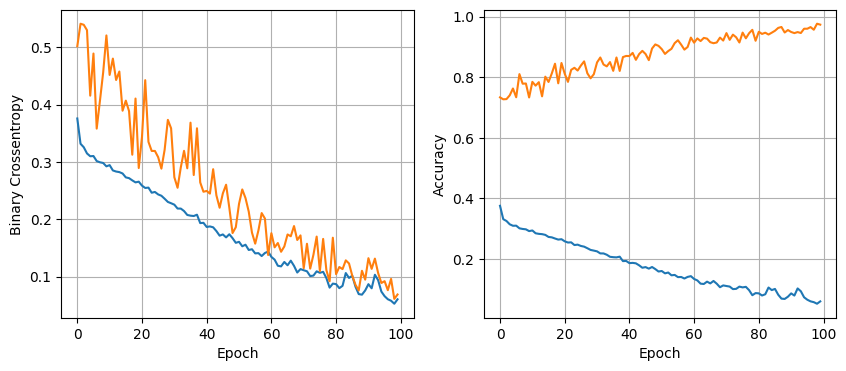

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8464 - loss: 0.9390
nodes: 128, droupout: 0, lr: 0.001, batch size 32


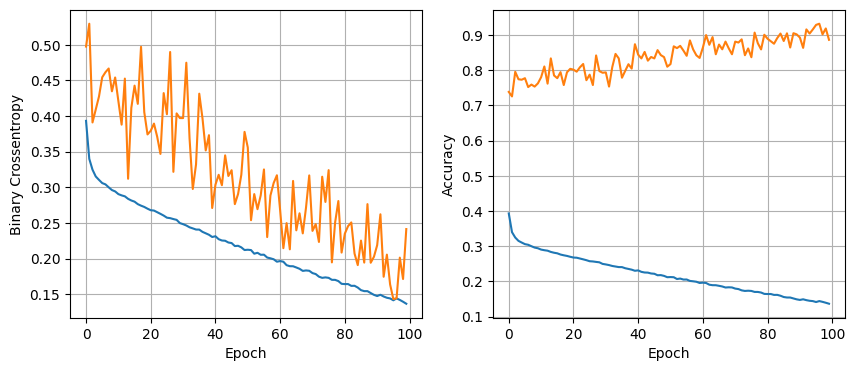

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8649 - loss: 0.4773  
nodes: 128, droupout: 0, lr: 0.001, batch size 64


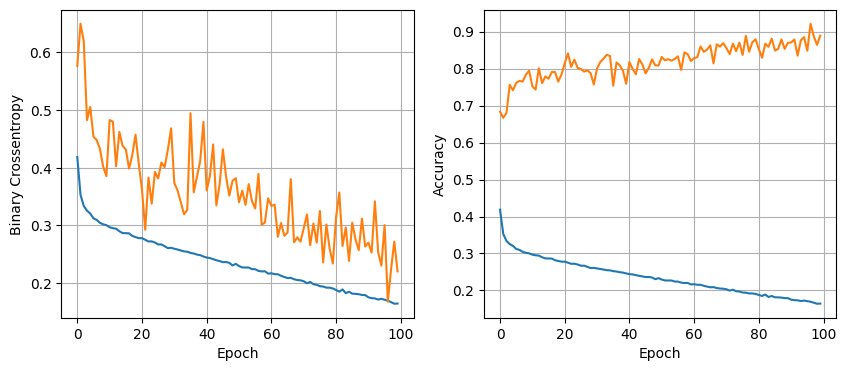

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8589 - loss: 0.4154  
nodes: 128, droupout: 0.2, lr: 0.01, batch size 32


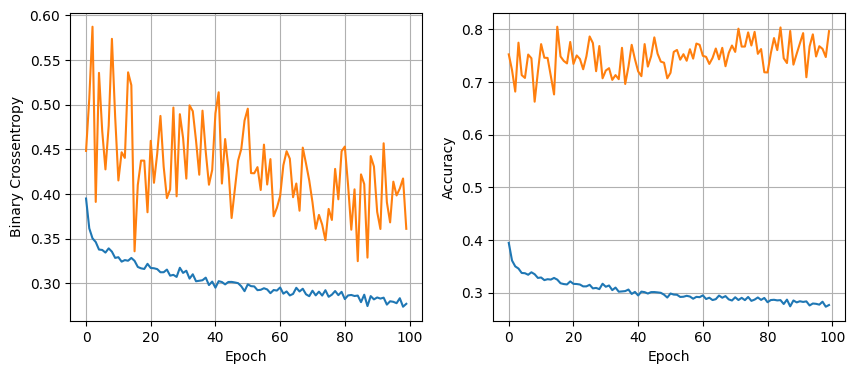

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8624 - loss: 0.3521
nodes: 128, droupout: 0.2, lr: 0.01, batch size 64


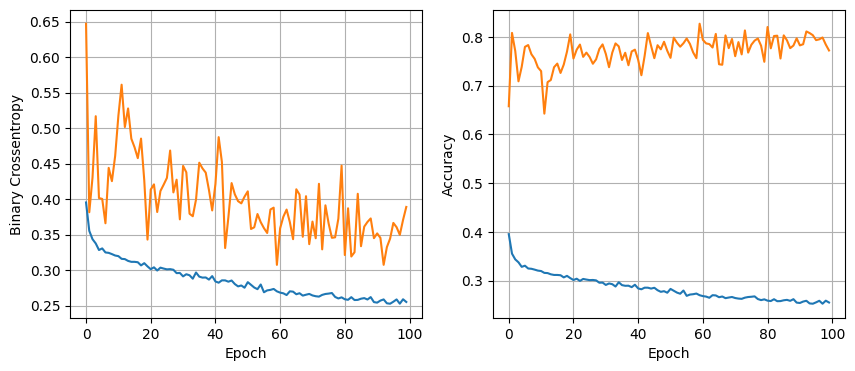

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8687 - loss: 0.3359
nodes: 128, droupout: 0.2, lr: 0.005, batch size 32


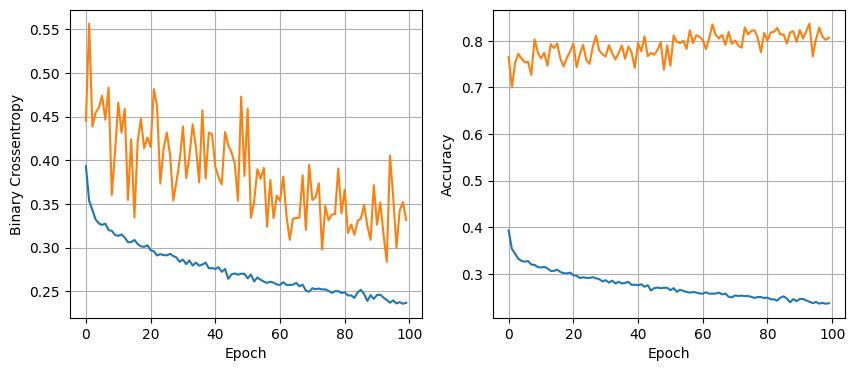

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8638 - loss: 0.3504  
nodes: 128, droupout: 0.2, lr: 0.005, batch size 64


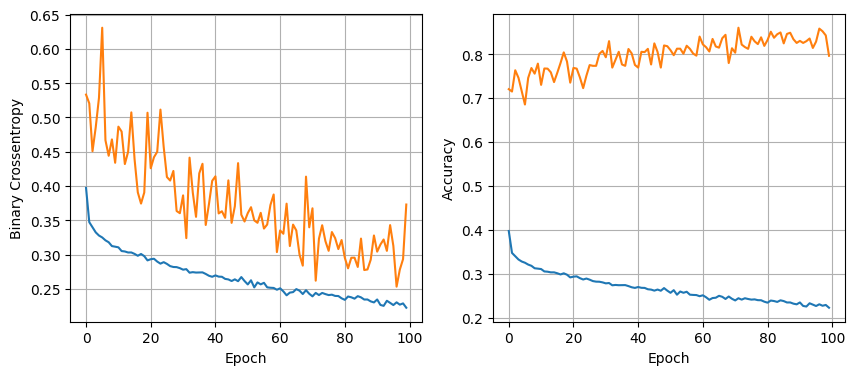

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8672 - loss: 0.3317  
nodes: 128, droupout: 0.2, lr: 0.001, batch size 32


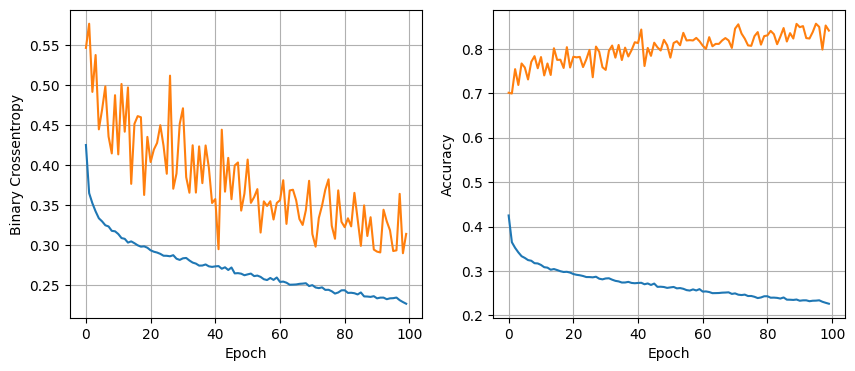

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8713 - loss: 0.3227  
nodes: 128, droupout: 0.2, lr: 0.001, batch size 64


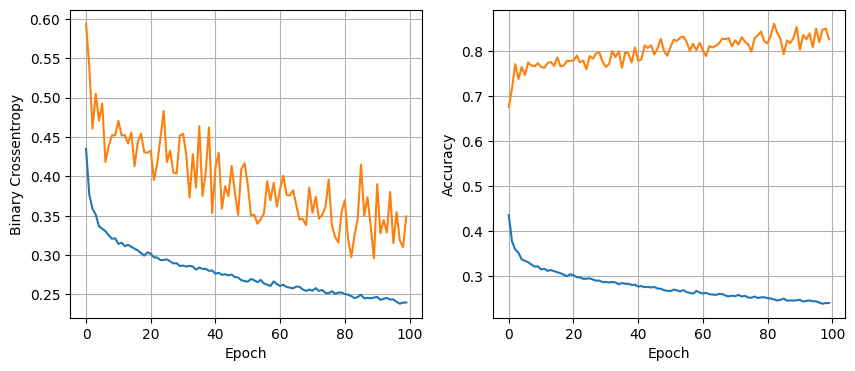

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8693 - loss: 0.3182  


In [18]:
least_val_lost = float('inf')
least_loss_model = None
epochs= 100 
for nodes in [16, 32, 128]:
    for dropout_prob in [0, 0.2]:
        for lr in [0.01, 0.005, 0.001]:
            for batch_size in [32, 64]:
                print(
                    f"nodes: {nodes}, droupout: {dropout_prob}, lr: {lr}, batch size {batch_size}"
                )
                model, history = train_model(
                    X_train=X_train, y_train=y_train, n_nodes=nodes, dropout_prob=dropout_prob, lr=lr, 
                    batch_size=batch_size, epochs=epochs
                )
                plot_history(history)
                val_loss = model.evaluate(X_val, y_val)[0]
                if val_loss < least_val_lost:
                    least_val_lost = val_loss
                    least_loss_model = model

In [19]:
y_predicts = least_loss_model.predict(X_test)
y_predicts = (y_predicts > 0.5).astype(int).reshape(-1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


In [20]:
print(classification_report(y_test, y_predicts))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1364
           1       0.87      0.95      0.91      2440

    accuracy                           0.87      3804
   macro avg       0.88      0.85      0.86      3804
weighted avg       0.88      0.87      0.87      3804

